In [96]:
!pip install yfinance
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [217]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
import yfinance as yf  
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [218]:
df = yf.download('AAPL','2015-01-01','2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [219]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.603205,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.910093,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.912342,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.247644,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.179300,237458000
...,...,...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497,69.623222,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,71.004593,93121200
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.977631,146266000


Text(0, 0.5, 'Open')

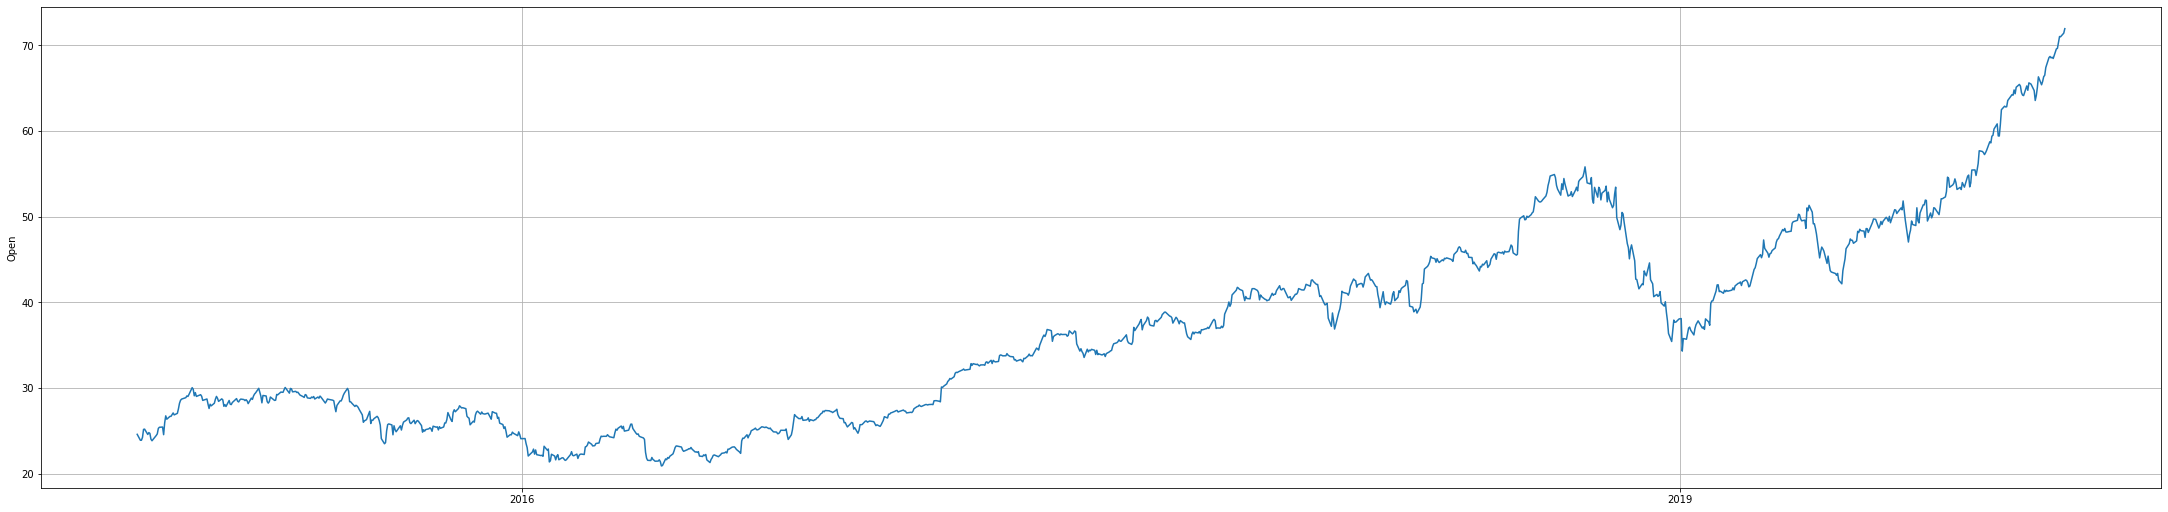

In [220]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig, ax = plt.subplots(1, figsize=(30, 7), constrained_layout=True)
ax.plot(df.index, df['Adj Close'])
ax.xaxis.set_major_locator(mdates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True)
ax.set_ylabel('Open')

## Method: Difference-GRU

In [221]:
# Taking adjusted price
df = df['Adj Close']
#df = pd.concat([df, df.diff()], axis=1)
#df.columns = ["Adj", "Diff"]
#df["Diff"][0] = 0.0

# Preprocessing using Min-Max Scalar
values = df.values
#scaler_1, scaler_2 = MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1))
scaler_1 =  MinMaxScaler(feature_range=(0, 1)) 
#scaled_1, scaled_2 = scaler_1.fit_transform(values[:,0].reshape(-1,1)), scaler_2.fit_transform(values[:,1].reshape(-1,1))
scaled_1 = scaler_1.fit_transform(values.reshape(-1,1))
#scaled = pd.DataFrame([scaled_1.reshape(-1), scaled_2.reshape(-1)])
scaled = pd.DataFrame(scaled_1)
#scaled = scaled.T

In [222]:
scaled.head(4)

,0
0,0.072311
1,0.058722
2,0.058767
3,0.065340


In [223]:
X = []
y = []
for i in range(scaled.iloc[:-10, :].shape[0]):
  X.append(scaled.iloc[i:i+10, :].values)
  y.append(np.array(scaled.iloc[i+10, 0]).reshape(1,-1))

X = np.array(X)
y = np.array(y)[:,0,:]

l = int(len(X)*0.80)
train_X, train_y = X[:l,:], y[:l]
test_X, test_y = X[l:,:], y[l:]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(998, 10, 1) (998, 1) (250, 10, 1) (250, 1)


In [224]:
model_gru = Sequential()
model_gru.add(GRU(70, activation="relu", return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(GRU(units=70, activation="relu", return_sequences=True))
model_gru.add(GRU(units=20, activation="relu"))
model_gru.add(Dense(units=1))
model_gru.compile(loss='mse', optimizer='adam')
model_gru.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_66 (GRU)                (None, 10, 70)            15330     
                                                                 
 gru_67 (GRU)                (None, 10, 70)            29820     
                                                                 
 gru_68 (GRU)                (None, 20)                5520      
                                                                 
 dense_22 (Dense)            (None, 1)                 21        
                                                                 
Total params: 50,691
Trainable params: 50,691
Non-trainable params: 0
_________________________________________________________________


In [225]:
# fit network
history_gru = model_gru.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y),  shuffle=False)

Epoch 1/50
16/16 [==============================] - 5s 57ms/step - loss: 0.0621 - val_loss: 0.2309
Epoch 2/50
16/16 [==============================] - 0s 23ms/step - loss: 0.0184 - val_loss: 0.0666
Epoch 3/50
16/16 [==============================] - 0s 23ms/step - loss: 0.0165 - val_loss: 0.0352
Epoch 4/50
16/16 [==============================] - 0s 23ms/step - loss: 0.0137 - val_loss: 0.0264
Epoch 5/50
16/16 [==============================] - 0s 24ms/step - loss: 0.0065 - val_loss: 0.0052
Epoch 6/50
16/16 [==============================] - 0s 24ms/step - loss: 0.0022 - val_loss: 7.5591e-04
Epoch 7/50
16/16 [==============================] - 0s 25ms/step - loss: 8.0574e-04 - val_loss: 7.8504e-04
Epoch 8/50
16/16 [==============================] - 0s 23ms/step - loss: 0.0013 - val_loss: 6.9780e-04
Epoch 9/50
16/16 [==============================] - 0s 24ms/step - loss: 0.0014 - val_loss: 9.2179e-04
Epoch 10/50
16/16 [==============================] - 0s 24ms/step - loss: 5.4992e-04 - va

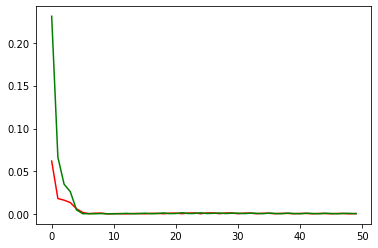

In [226]:
pyplot.plot(history_gru.history['loss'], label='GRU train', color='red')
pyplot.plot(history_gru.history['val_loss'], label='GRU test', color= 'green')

In [227]:
results = model_gru.evaluate(test_X, test_y, batch_size=64)
print("test loss:", results)

4/4 [==============================] - 0s 10ms/step - loss: 7.4815e-04
test loss: 0.000748145452234894


In [ ]:
import time
preds= []
start = time.time() 
for i in range(len(test_y)):
  preds.append(model_gru.predict(test_X[np.newaxis,i])[0])
end = time.time()
print("Time taken to predict:",end-start)
preds_1 = np.array(preds)
act = scaler_1.inverse_transform(test_y[:,0].reshape(-1,1))
preds_2 = scaler_1.inverse_transform(np.array(preds_1[:,0]).reshape(-1,1))

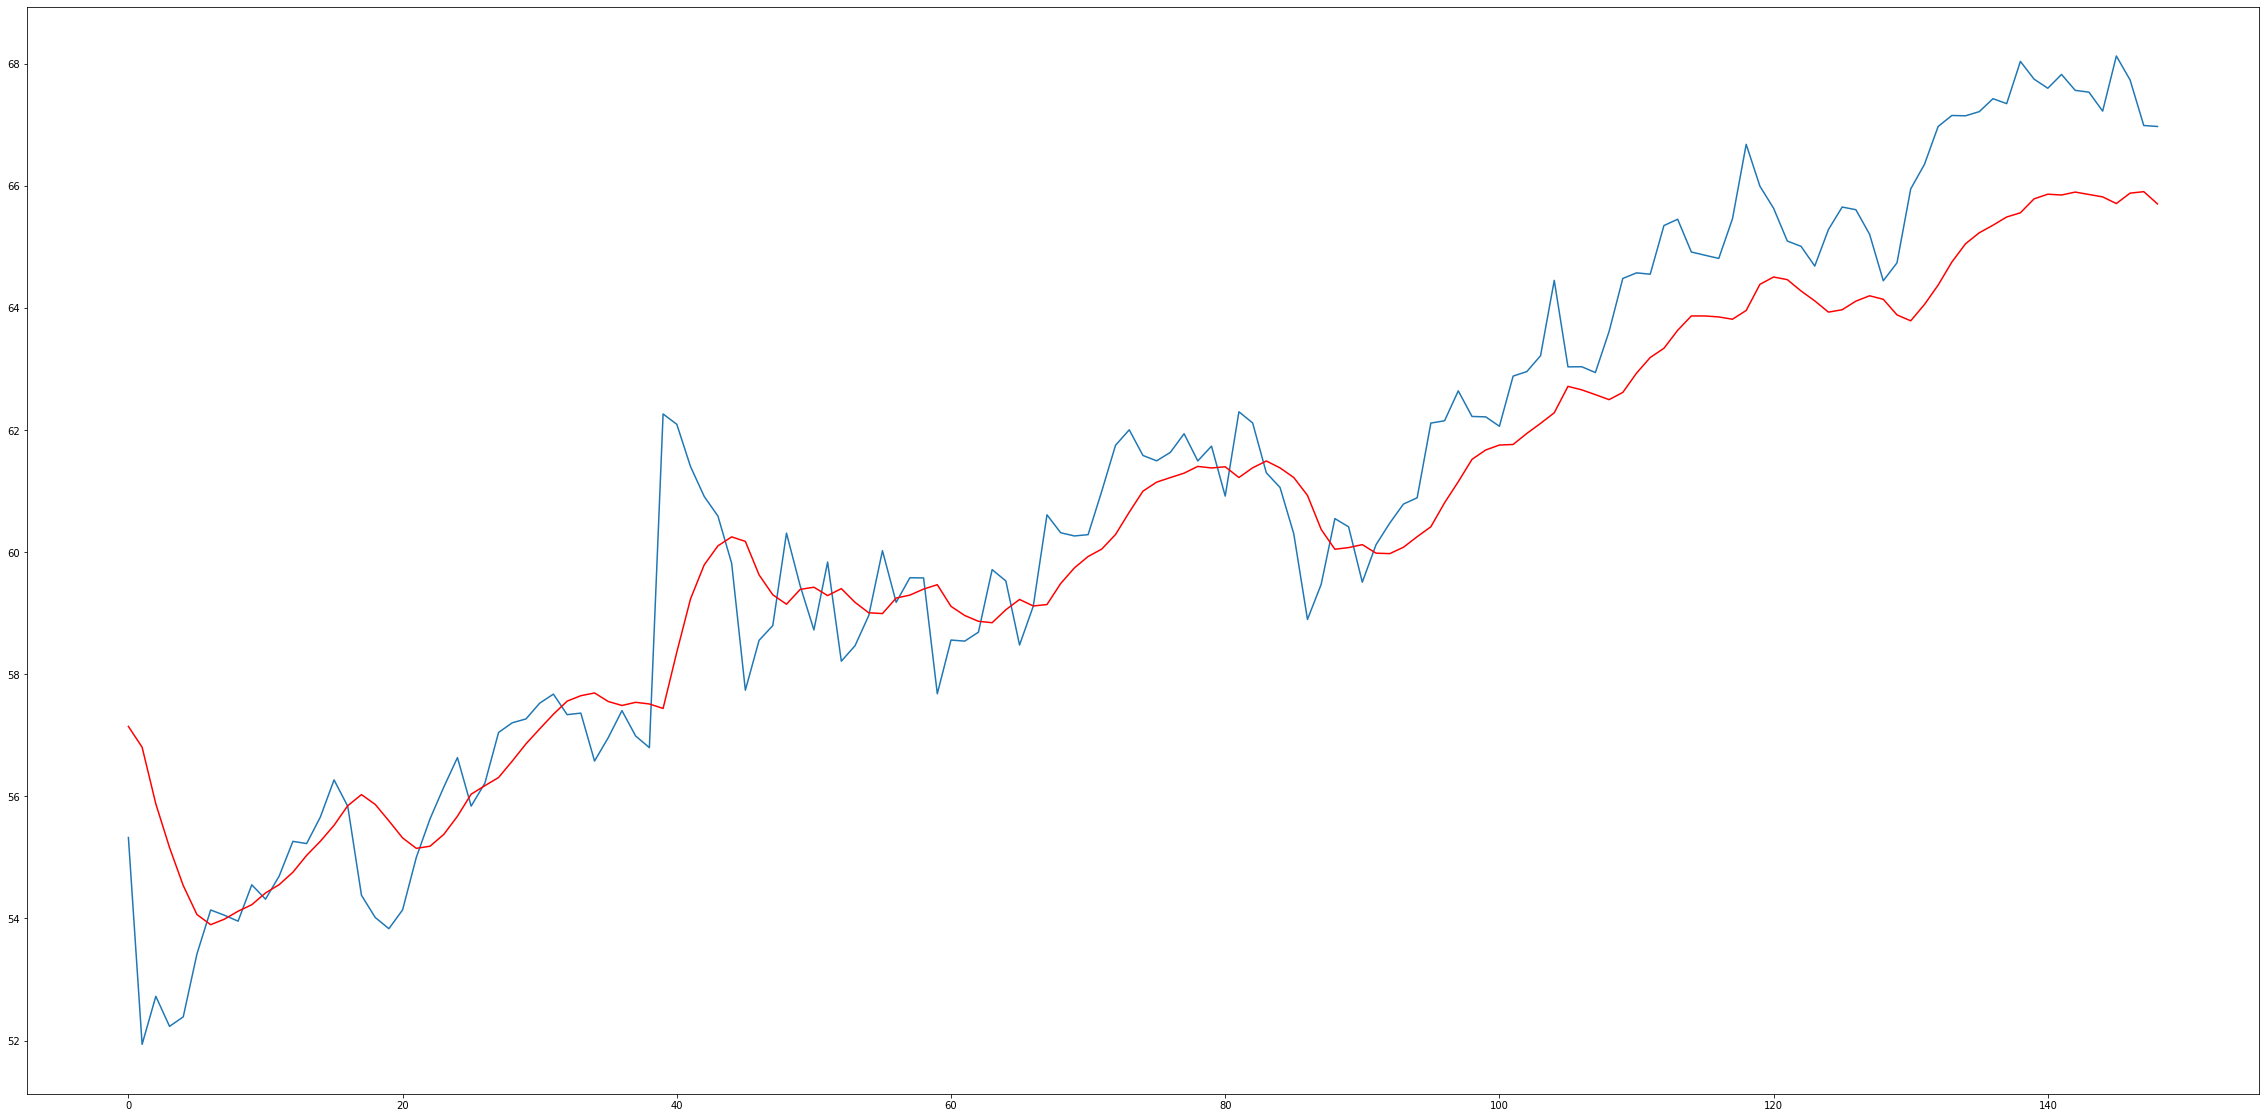

In [ ]:
pyplot.figure(figsize=(40, 20))
pyplot.plot(act)
pyplot.plot(preds_2, color='red')
pyplot.savefig('22_year_60_lag.png')

In [ ]:
model_gru.save("gru_model.h5")